In [1]:
# check version
from platform import python_version
print(python_version())

3.5.6


In [2]:
# # install necessary modules
# import sys
# !{sys.executable} -m pip install pandas_datareader

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 17, 5

import wget
from datetime import date
import os
import numpy as np
import pandas as pd
import datetime as dt
import math
import yfinance as yf
import bs4 as bs
import pickle
import requests
import time


## Шаг 0. Постановка задачи

__Задача:__ Реализовать торговое приложение на языке Python, генерирующее сигнал к покупке или продаже акции.

__Описание проблемы:__ Для реализации стратегии необходимо предсказание среднего значения за будущие 10 дней. Качество предсказывающей модели будем оценивать по RMSE.

__План:__

1) Определение источников данных, настройка системы сбора данных

2) Проверка эффективности торговой стратегии на известных данных

3) Создание дополнительных признаков

4) Выбор модели, настройка параметров; отбор признаков

5) Бэктестинг на данных тех периодов, которые не участвовали в настройке модели (например, используя www.quantopian.com)

6) Подведение итогов

__Критерии успеха:__ Качество предсказаний модели + Положительный торговый результат.

## Шаг 1. Загрузка данных

Загрузим исторические данные о котировках акций компании NVIDIA (NVDA). Посмотрим, как менялась цена акций во времени.

Данные будем брать с Yahoo Finance (https://pypi.org/project/yfinance/)

In [4]:
import yfinance as yf

stock = yf.Ticker("NVDA")
data = stock.history(period="max")

/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
data.shape

(5221, 7)

In [6]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22,1.612817,1.800019,1.430415,1.512016,67867200.0,0.0,0.0
1999-01-25,1.632017,1.689617,1.512015,1.670417,12762000.0,0.0,0.0
1999-01-26,1.689618,1.723218,1.516816,1.540816,8580000.0,0.0,0.0
1999-01-27,1.545616,1.584016,1.459215,1.536015,6109200.0,0.0,0.0
1999-01-28,1.536016,1.545616,1.521616,1.531216,5688000.0,0.0,0.0


In [7]:
data.drop(columns=['Stock Splits', 'Dividends'], inplace=True)

/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


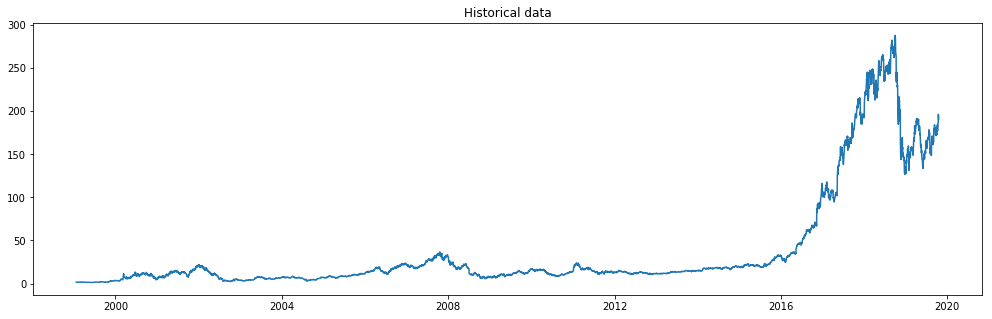

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 17, 5

plt.plot(data.Close);
plt.title('Historical data');

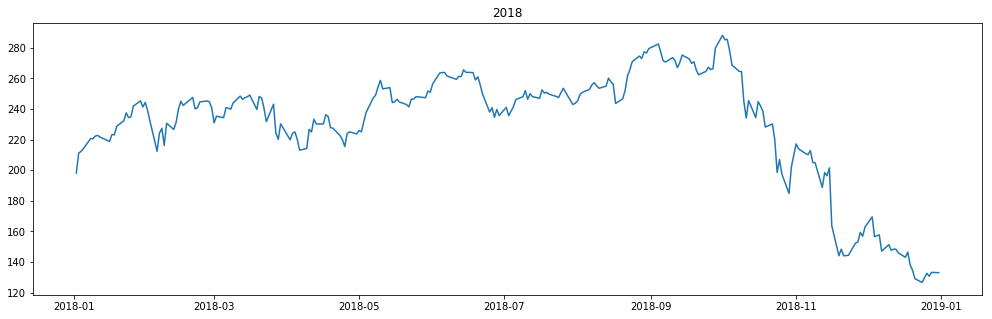

In [9]:
plt.plot(data[(data.index >= '2018-01-01') & (data.index < '2019-01-01')]['Close']);
plt.title('2018');

## Шаг 2. Определение торговой стратегии

Чтобы даже самые точные предсказания не оказались бесполезными, посмотрим на уже известных данных, принесет ли планируемая стратегия прибыль.

Стратегию будем использовать следующую: 
* Вход: если средняя цена последующих 10 дней на 2% больше текущей, то покупаем
* Выход: если средняя цена последующих 10 дней на 1% меньше текущей, то продаем
* Сколько покупаем: покупаем количество соразмерно 1% имеющихся средств
* Сколько продаем: продаем 10% от имеющихся акций


In [10]:
# Проведем проверку на уже известных данных: 
# если бы алгоритм точно предсказывал цену ближайших 5-и дней, то получили ли бы мы профит?
# Найдем кумулятивный доход

def test_historical(start_period, end_period):
    
    price = data[(data.index >= start_period) & (data.index < end_period)]['Close'].copy()
    comis = 0.0002 # 0.02%
    
    money=[]
    stocks=[]
    pnl=[]
    stocks_sum=0
    money_sum=1000000
    n1=10
    n2=10


    for i in range(len(price)-n1):
        cur_price = float(price[i:i+1])
        avg_b = np.average(price[i+1:i+1+n1])
        avg_s = np.average(price[i+1:i+1+n2])

        pnl.append(money_sum + stocks_sum*cur_price)

        if avg_b > 1.02*float(cur_price):
            # buy
            how_many=(money_sum*0.01)/(cur_price*(1+comis))
            if how_many>=1:
                
                money_sum-=cur_price*math.ceil(how_many)*(1+comis)
                stocks_sum+=math.ceil(how_many)

                money.append(money_sum)
                stocks.append(stocks_sum)
                # print('Buying ' + str(math.ceil(how_many)))
                
        elif avg_s < 0.99*float(cur_price):
            # sell
            if stocks_sum>0:
                
                how_many=math.ceil(stocks_sum*0.1)
                
                money_sum+=(1-comis)*cur_price*how_many
                stocks_sum-=how_many

                money.append(money_sum)
                stocks.append(stocks_sum)
                # print('Selling ' + str(math.ceil(how_many)))
    
    print('Number of buy/sell operations: ' + str(len(stocks)))
    print('Profit percent (above initial sum): ' +\
        str(np.round(((stocks[-1]*float(price[-1:]) + money[-1])/1000000 - 1)*100,4)) + '%')
    plt.plot(pnl);
    plt.title('PnL for period: ' + start_period + ' - ' + end_period)

Number of buy/sell operations: 179
Profit percent (above initial sum): 5.4418%


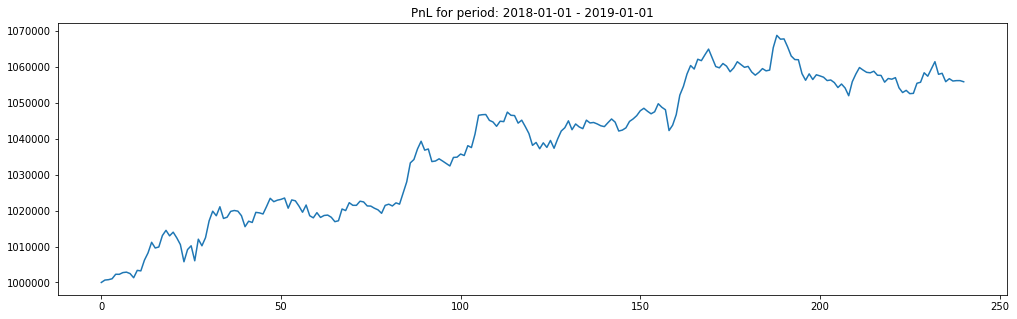

In [11]:
test_historical('2018-01-01', '2019-01-01')

Number of buy/sell operations: 179
Profit percent (above initial sum): 24.5501%


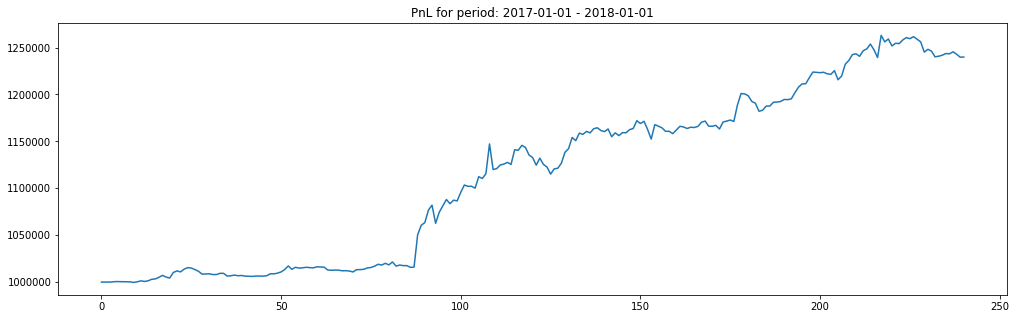

In [12]:
test_historical('2017-01-01', '2018-01-01')

Number of buy/sell operations: 172
Profit percent (above initial sum): 46.9998%


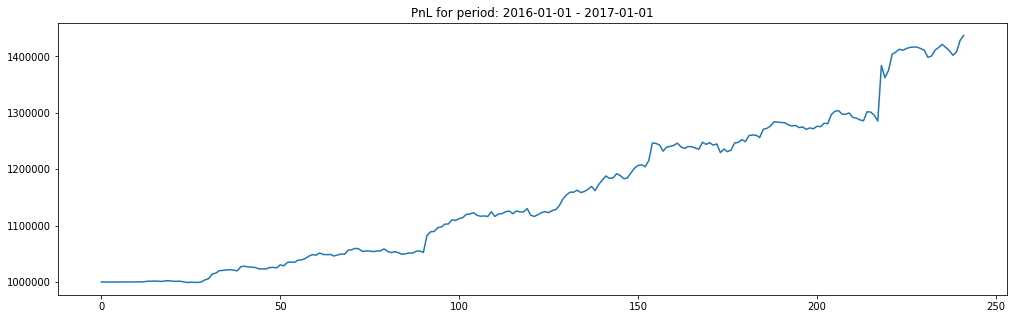

In [13]:
test_historical('2016-01-01', '2017-01-01')

Number of buy/sell operations: 820
Profit percent (above initial sum): 52.1619%


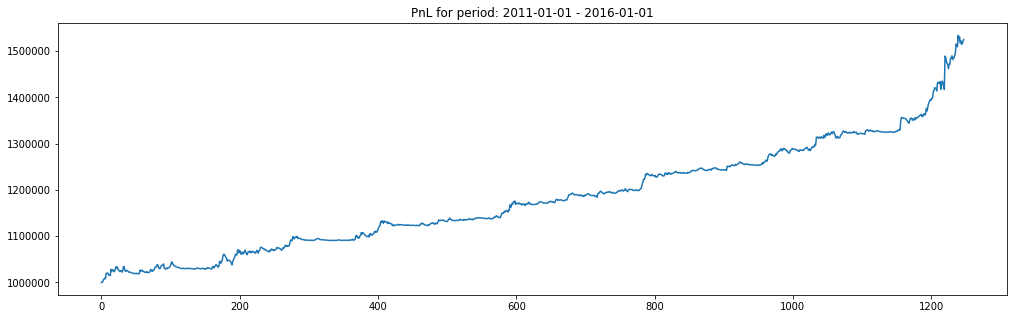

In [14]:
test_historical('2011-01-01', '2016-01-01')

Получили очень неплохие результаты, профит по годам:

* 2018: 5.5%
* 2017: 24.6%
* 2016: 47%

## Шаг 3. Добавление новых признаков

Создадим колонку с целевым значением - среднее за будущие 10 дней

In [15]:
data['Y']=data.Close.rolling(10).mean().shift(-10)
# For every row in dataset we count mean of the NEXT period,
# Today's value not included

Существует фондовый индекс - S&P 500, в корзину которого включено 500 избранных акционерных компаний США, имеющих наибольшую капитализацию. Индекс S&P 500 вместе с индексом Dow Jones определяют эффективность американской экономики. Но в отличие от Dow Jones, включающего всего 30 американских акций, индекс S&P 500 охватывает более широкую часть рынка и признается более объективным. 

Всвязи с этим можем предположить, что наличие в датасете этого индекса может улучшить предсказания модели. Поэтому добавим значения S&P 500 с 1999-01-22 (поскольку NVIDIA на бирже начала котироваться именно в эту дату). Биржевой фонд SPDR® S&P 500 (биржевой тикер SPY) создан для получения инвестиционного результата, который соответствует доходности индекса S&P500. В состав активов этого фонда входят все 500 акций индекса S&P 500 в пропорциях, в которых эти ценные бумаги входят в индекс. В работе будет использоваться именно SPY.

Для уверенности в схожести SPY и S&P 500 загрузим данные по обоим и посмотрим на их нормализованные значения - действительно ли они схожи:

In [16]:
# Download SPY data
ticker = yf.Ticker("SPY")
spy_data = ticker.history(period="max")
spy_data = spy_data[spy_data.index >= '1999-01-22'].reset_index().rename(columns={
    'Open':'Open_snp500', 'High':'High_snp500', 'Low':'Low_snp500', 'Close':'Close_snp500', 
    'Volume':'Volume_snp500'}).drop(columns=['Dividends', 'Stock Splits']).set_index('Date')

# Download S&P 500 data
ticker = yf.Ticker("^GSPC")
snp500_data = ticker.history(period="max")
snp500_data = snp500_data[snp500_data.index >= '1999-01-22']

In [17]:
# This dataset we will use
print(spy_data.shape, snp500_data.shape)
spy_data.head()

(5220, 5) (5220, 7)


,Open_snp500,High_snp500,Low_snp500,Close_snp500,Volume_snp500
Date,,,,,
1999-01-22,83.467861,84.642563,83.232921,83.766876,7522300
1999-01-25,84.258134,84.749373,83.318373,84.621223,5700300
1999-01-26,84.834818,86.159027,84.493087,86.159027,6047000
1999-01-27,86.372600,86.543466,84.856167,85.155182,7399400
1999-01-28,85.603712,86.778413,85.560995,86.586189,5961700


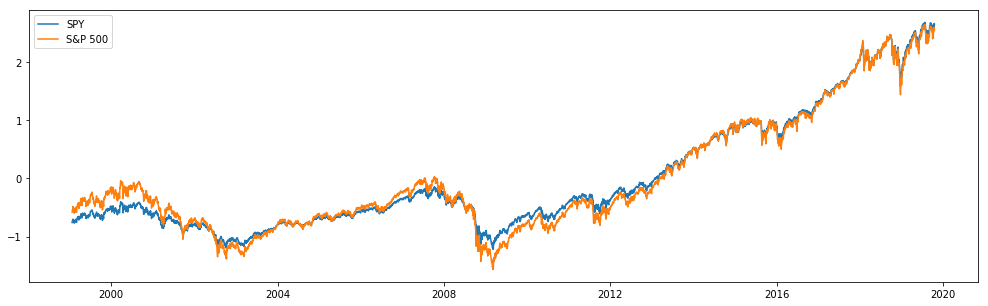

In [18]:
# Check normalized indices
spy = spy_data.Close_snp500
snp500 = snp500_data.Close

plt.plot((spy -spy.mean())/spy.std(), label='SPY');
plt.plot((snp500 - snp500.mean())/snp500.std(), label='S&P 500');
plt.legend();

По графику видно, что значения индексов действительно очень близки. Посмотрим теперь на взаимосвязь индекса SPY(S&P 500) и стоимости акций NVDA:

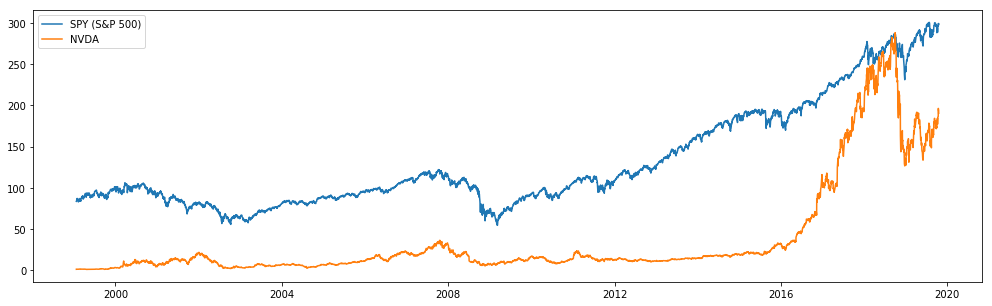

In [19]:
plt.plot(spy_data.Close_snp500, label='SPY (S&P 500)');
plt.plot(data.Close, label='NVDA');
plt.legend();

С виду сильной зависимости между рядами нет. В любом случае, посмотрим на корреляцию между ними. Во временном ряде с ценами NVDA присутствует дата, которой нет в S&P 500. Поэтому, чтобы иметь возможность посчитать корреляцию, удалим эту строку в котировках NVDA и выведем результат.

In [20]:
# Here would be error
# print(np.corrcoef(spy_data.Close_snp500, data.Close))

In [21]:
# Date in NVDA prices that doesn't exist in S&P500 (in Yahoo)
for i in data.index:
    if i not in spy_data.index:
        d=i
        print(d)

2001-09-12 00:00:00


In [22]:
print(np.corrcoef(
    spy_data.Close_snp500, 
    data.drop(index=d).Close))

[[1.         0.85275032]
 [0.85275032 1.        ]]


Между переменными наблюдается довольно сильная корреляция, что подтверждает необходимость использования S&P 500.

In [23]:
# Add S&P 500 to our df
data = pd.merge(data.reset_index(), spy_data, on='Date', how='left').set_index('Date').dropna()

Теперь разделим данные на Train, Validation и Test

In [24]:
# Train
df_train = data[data.index < '2016-01-01'].copy()

# Validation
df_valid = data[(data.index >= '2016-01-01') & (data.index < '2018-01-01')].copy()

# Test
df_test = data[data.index >= '2018-01-01'].copy()

Далее нагенерируем признаков

In [25]:
from sklearn.preprocessing import PolynomialFeatures


def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi


def add_features(data):
    df = data.copy()
    
    # Shifts
    df['shift1'] = df.Close.shift(1).fillna(0)
    df['shift2'] = df.Close.shift(2).fillna(0)
    df['shift3'] = df.Close.shift(3).fillna(0)
    df['shift5'] = df.Close.shift(5).fillna(0)
    df['shift10'] = df.Close.shift(10).fillna(0)
    df['shift15'] = df.Close.shift(15).fillna(0)
    df['shift30'] = df.Close.shift(30).fillna(0)
    
    # Differences
    df['dif1'] = df.Close.sub(df.Close.shift(2), fill_value=0)
    df['dif3'] = df.Close.sub(df.Close.shift(4), fill_value=0)
    df['dif5'] = df.Close.sub(df.Close.shift(6), fill_value=0)
    df['dif10'] = df.Close.sub(df.Close.shift(11), fill_value=0)
    df['dif15'] = df.Close.sub(df.Close.shift(16), fill_value=0)
    df['dif30'] = df.Close.sub(df.Close.shift(31), fill_value=0)

    # EMAs
    df['ema2'] = df.Close.ewm(2,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema3'] = df.Close.ewm(3,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema5'] = df.Close.ewm(5,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema10'] = df.Close.ewm(10,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema15'] = df.Close.ewm(15,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema30'] = df.Close.ewm(30,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema90'] = df.Close.ewm(90,ignore_na=False,min_periods=0,adjust=True).mean()
    
    # RSI
    df['rsi5'] = rsi(df.Close,5)
    df['rsi10'] = rsi(df.Close,10)
    df['rsi15'] = rsi(df.Close,15)
    df['rsi30'] = rsi(df.Close,30)
    
    df = df.fillna(0)
    
#     # Polynomial
#     y = df.Y.copy()
#     poly_features = df.drop(columns=['Y']).copy()
#     input_names = poly_features.columns
    
#     poly_transformer = PolynomialFeatures(degree = 2)
#     poly_transformer.fit(poly_features)
#     poly_features = poly_transformer.transform(poly_features)

#     # Get names for new polynomial features
#     poly_names=poly_transformer.get_feature_names(input_features = input_names)
#     poly_features = pd.DataFrame(poly_features, columns = poly_names)
#     poly_features.drop(columns=['1'], inplace=True)
    
#     df = pd.concat([poly_features.set_index(y.index), y], axis=1)

    print("Any null data : %s"%(df.isnull().values.any()))
    print("Shape: " + str(df.shape))
    
    return df

In [26]:
df_train = add_features(df_train)
df_valid = add_features(df_valid)
df_test = add_features(df_test)

Any null data : False
Shape: (4254, 35)
Any null data : False
Shape: (503, 35)
Any null data : False
Shape: (443, 35)


In [27]:
df_train.head(3)

,Open,High,Low,Close,Volume,Y,Open_snp500,High_snp500,Low_snp500,Close_snp500,...,ema3,ema5,ema10,ema15,ema30,ema90,rsi5,rsi10,rsi15,rsi30
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-22,1.612817,1.800019,1.430415,1.512016,67867200.0,1.500015,83.467861,84.642563,83.232921,83.766876,...,1.512016,1.512016,1.512016,1.512016,1.512016,1.512016,0.0,0.0,0.0,0.0
1999-01-25,1.632017,1.689617,1.512015,1.670417,12762000.0,1.479855,84.258134,84.749373,83.318373,84.621223,...,1.602531,1.598416,1.594988,1.593771,1.592515,1.591654,0.0,0.0,0.0,0.0
1999-01-26,1.689618,1.723218,1.516816,1.540816,8580000.0,1.466895,84.834818,86.159027,84.493087,86.159027,...,1.575843,1.575629,1.575185,1.574969,1.574714,1.574520,0.0,0.0,0.0,0.0


In [28]:
# Divide Y from X
x_train, y_train = df_train.drop(columns=['Y']), df_train.Y
x_valid, y_valid = df_valid.drop(columns=['Y']), df_valid.Y
x_test, y_test = df_test.drop(columns=['Y']), df_test.Y

Применим метод главных компонент, чтобы определить важность признаков. Перед этим нормализуем данные (среднее и стандартное отклонение будем считать только по тренировочным данным).

In [29]:
def normalize(x_train, x, y, period):
    x_norm = (x - x_train.mean())/x_train.std()
    y_norm = x_norm.Close.rolling(10).mean().shift(-10)[:-10]
    x_norm = x_norm[:-10]
    
    return x_norm, y_norm

norm_period = 366

x_norm_valid, y_norm_valid = normalize(x_train, x_valid, y_valid, norm_period)
x_norm_train, y_norm_train = normalize(x_train, x_train, y_train, norm_period)
x_norm_test, y_norm_test = normalize(x_train, x_test, y_test, norm_period)

Number of features to explain 99% of variance in data: 12


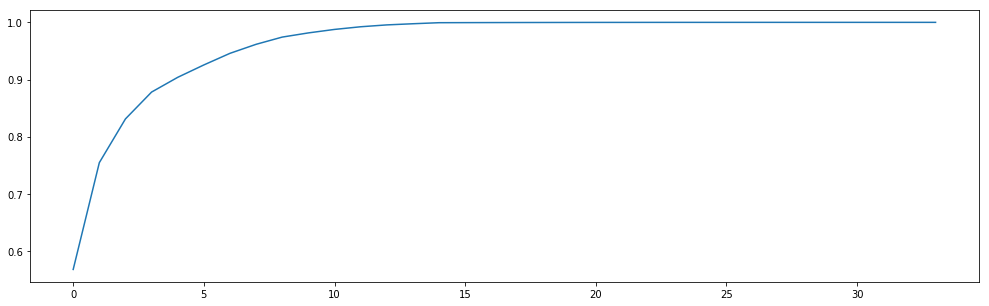

In [30]:
# How many components do we need
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_norm_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum);

perc=0.99
print('Number of features to explain {}% of variance in data: {}'.format(
    int(perc*100), np.argmax(cumsum >= perc)+1))

Согласно результатам аналза главных компоненет, нам достаточно 12-и признаков для объяснения 99% дисперсии данных. Отобразим эти признаки

In [31]:
pca_best = pd.DataFrame({'feature': x_train.columns, 
              'explained_var': pca.explained_variance_ratio_}).sort_values(
    by='explained_var', ascending=False)[:12]
pca_best

,explained_var,feature
0,0.567824,Open
1,0.186770,High
2,0.076548,Low
3,0.046934,Close
4,0.025774,Volume
5,0.021672,Open_snp500
6,0.020310,High_snp500
7,0.015772,Low_snp500
8,0.012634,Close_snp500
9,0.007307,Volume_snp500


In [32]:
pca = PCA(n_components = 12)

x_train_pca = pd.DataFrame(pca.fit_transform(x_norm_train))
x_valid_pca = pd.DataFrame(pca.fit_transform(x_norm_valid))
x_test_pca = pd.DataFrame(pca.fit_transform(x_norm_test))

## Шаг 4-5. Выбор модели. Бэктестинг.

Пропишем функцию RMSE для оценки результатов работы моделей и построим сначала бейзлайн модель - линейную регрессию без нормализации, затем с нормализацией, и затем с нормализацией и только теми признаками, которые мы определили как важные

In [33]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calc_metrics(y_pred, y_valid):
    print('\nRoot mean squared error: %.2f' % rmse(y_pred, y_valid))
    print('Variance score: %.2f' % r2_score(y_pred, y_valid))

    plt.scatter(y_pred, y_valid,  color='black')
    plt.plot(y_valid, y_valid, color='blue', linewidth=3)
    plt.xlabel('Y(True)')
    plt.ylabel('Y(Predicted)')
    plt.show()

### Linear Regression

NOT NORMALIZED

Root mean squared error: 6.69
Variance score: 0.99


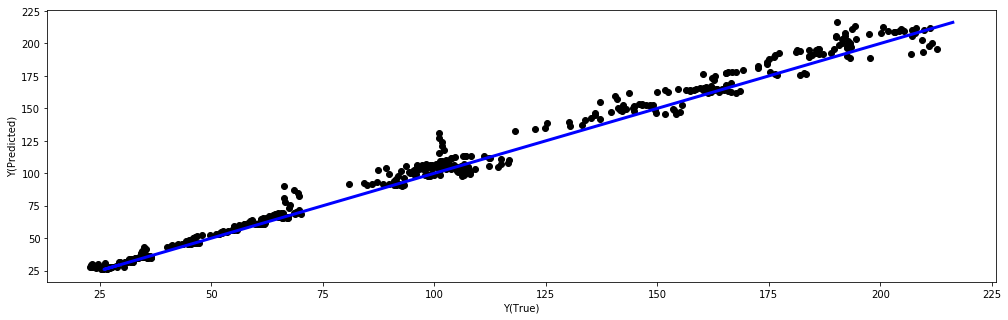

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def build_lr(x_train, y_train, x_valid, y_valid):
    lr = LinearRegression() # create model
    lr.fit(x_train, y_train) # train model
    y_pred = lr.predict(x_valid) # predict

    calc_metrics(y_pred, y_valid)
    
print('NOT NORMALIZED')
build_lr(x_train, y_train, x_valid, y_valid)

NORMALIZED

Root mean squared error: 0.94
Variance score: 0.99


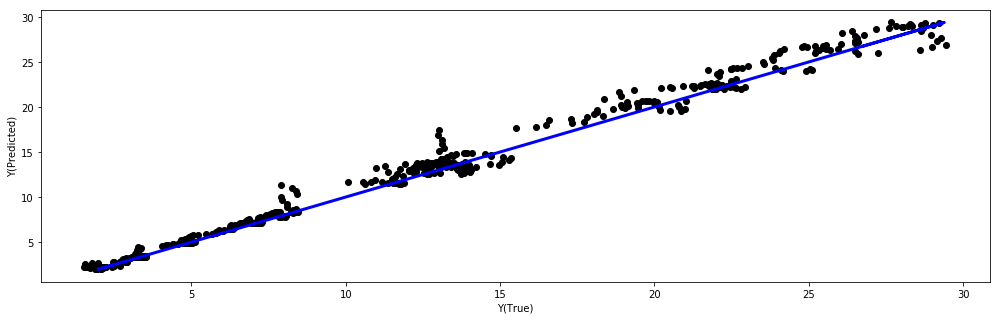

In [35]:
print('NORMALIZED')
build_lr(x_norm_train, y_norm_train, x_norm_valid, y_norm_valid)

NORMALIZED AND IMPORTANT DUE TO PCA

Root mean squared error: 0.91
Variance score: 0.99


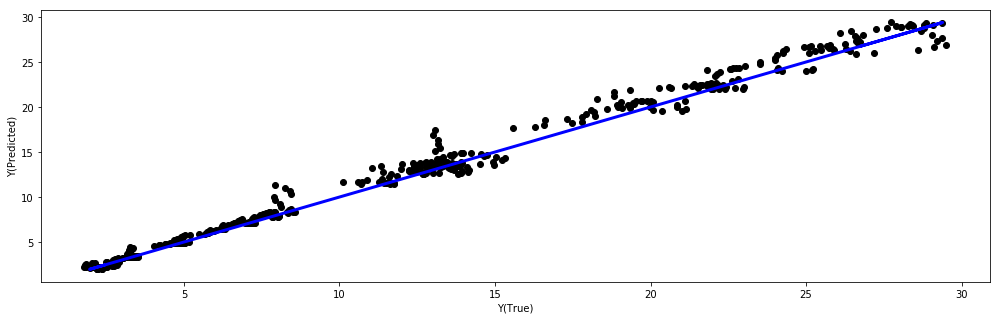

In [36]:
print('NORMALIZED AND IMPORTANT DUE TO PCA')
build_lr(x_norm_train[list(pca_best.feature)], y_norm_train, x_norm_valid[list(pca_best.feature)], y_norm_valid)

Код для бэктестинга модели с линейной регрессией и отобранными PCA нормализованными фичами на www.quantopian.com представлен ниже(после прохождения по ссылке - Research - Algorythms - New Algorythm - вставляем в черное окно в левой части экрана необходимый код).

Каждый день мы берем информацию за предудущие 366*5 дней, обучаем на ней модель и делаем предсказание. Учитываем также комиссию = 0.001.

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def initialize(context):
    """
    Called once at the start of the algorithm.
    """   
    context.stocks = symbols('NVDA')
    context.n_bars = 366*5
    
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=1))

    # Rebalance every day, 1 hour after market open.
    schedule_function(my_trade_func, date_rules.every_day(), time_rules.market_open(hours=1))

    
def get_train_sets(data, context, stock):
    """"Does Feature engineering"""
    close_hist = data.history(stock, 'close', context.n_bars, '1d')
    low_hist = np.ravel(np.array(
            data.history(stock, 'low', context.n_bars, '1d')))
    high_hist = np.ravel(np.array(
            data.history(stock, 'high', context.n_bars, '1d')))
    open_hist = np.ravel(np.array(
            data.history(stock, 'open', context.n_bars, '1d')))
    volume_hist = np.ravel(np.array(
            data.history(stock, 'volume', context.n_bars, '1d')))

#     ema2=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                    ).ewm(2,ignore_na=False,min_periods=0,adjust=True).mean())
#     ema3=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                    ).ewm(3,ignore_na=False,min_periods=0,adjust=True).mean())
#     ema5=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                    ).ewm(5,ignore_na=False,min_periods=0,adjust=True).mean())
#     ema10=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).ewm(10,ignore_na=False,min_periods=0,adjust=True).mean())
#     ema15=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).ewm(15,ignore_na=False,min_periods=0,adjust=True).mean())
#     ema30=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).ewm(30,ignore_na=False,min_periods=0,adjust=True).mean())
    shift1=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(1))
    shift2=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(2))
#     shift3=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).shift(3))
#     shift5=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).shift(5))
#     shift10=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).shift(10))
#     shift15=np.array(pd.Series(np.ravel(np.array(close_hist))
#                                     ).shift(15))
    spy=symbol('SPY')
    close_spy = np.ravel(np.array(
            data.history(spy, 'close', context.n_bars, '1d')))
    open_spy = np.ravel(np.array(
            data.history(spy, 'open', context.n_bars, '1d')))
    high_spy = np.ravel(np.array(
            data.history(spy, 'high', context.n_bars, '1d')))
    low_spy = np.ravel(np.array(
            data.history(spy, 'low', context.n_bars, '1d')))
    volume_spy = np.ravel(np.array(
            data.history(spy, 'volume', context.n_bars, '1d')))
    
    y_train=np.array(pd.Series(np.ravel(np.array(close_hist))
                                      ).rolling(10).mean().shift(-10))
    x_train = np.c_[np.ravel(np.array(close_hist)),
                    low_hist, high_hist, open_hist, volume_hist,
#                     ema2, ema3, ema5, ema10, ema15, ema30,
                    shift1, shift2, 
#                     shift3, shift5, shift10, shift15,
                    close_spy, open_spy, high_spy, low_spy, volume_spy
                   ]
    x_train[np.isnan(x_train)] = 0

    # Normalize
    x_norm = (x_train - x_train.mean())/x_train.std()
    y_norm = np.array(pd.Series(x_norm[:, 0]).rolling(10).mean().shift(-10))
    x_norm = x_norm
    
    return x_norm, y_norm

def my_trade_func(context,data):
    """Execute orders according to our schedule_function() timing."""   
    symbols('NVDA')
    for stock in context.stocks:   
        
        try:
            x_train, y_train = get_train_sets(data, context, stock)
            x_test = x_train[-1:]
            x_train, y_train = x_train[:-10], y_train[:-10]

            lr = LinearRegression() # create model
            lr.fit(x_train, y_train) # train model
            y_pred = lr.predict(x_test[-1:])[0] # predict
            
            cur_price = data.current(stock, 'price')
            
            print('Prediction ' + str(y_pred) + ', current price ' + str(cur_price))
            
            # Finally trade itself
            if y_pred > 1.02*float(cur_price):
                order_percent(stock,0.01)
            elif y_pred < 0.99*float(cur_price):
                order_target_percent(stock,-0.1)

        except Exception as e:
            print(str(e))

    record('Leverage',context.account.leverage)
    record('Stock price', cur_price)

Результат на указанный период и начальную сумму следующий (фичи нормализованы и отобраны):

<img src="norm pca.png">

Точно такой же результат был получен с нормализацией, но без отбора фичей. Теперь попробуем не применять нормализацию, но отобрать важные:

<img src="pca no norm.png">

И наконец вовсе без нормализации и отбора:

<img src="no norm no pca.png">

Как видим, нормализация и отбор признаков как по отдельности, так и вместе не дают улучшения результатов, и даже дают их ухудшение

### Random Forest Regressor

/Users/mary/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature importances:
[8.17236038e-03 2.28304139e-02 3.78542644e-01 5.16062676e-01
 4.35026613e-04 5.83048504e-04 5.72220843e-04 6.59383772e-04
 5.06328447e-04 5.83262928e-04 1.23745783e-02 7.78896751e-04
 4.78580560e-04 2.38325301e-04 2.97094024e-04 4.20247377e-04
 5.43161165e-04 2.85429885e-04 2.26544714e-04 2.65094643e-04
 3.42880804e-04 6.15594252e-04 4.61465234e-04 1.36556606e-02
 3.28196466e-02 7.05812703e-04 3.79961894e-04 6.12409835e-04
 1.03131126e-03 2.77185895e-03 2.01457967e-04 3.01953742e-04
 6.89873357e-04 5.54794580e-04]

Root mean squared error: 92.03
Variance score: -5808.41


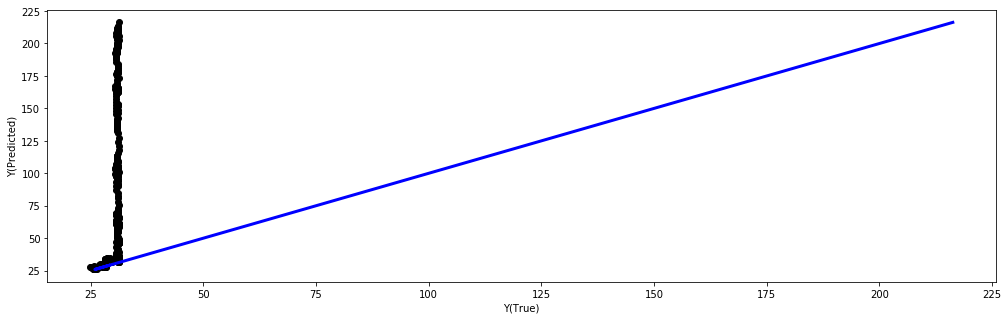

In [37]:
from sklearn.ensemble import RandomForestRegressor
 
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_valid)

print('Feature importances:')
print(rf.feature_importances_)
calc_metrics(y_pred, y_valid)

Результат получили совершенно непригодный для использования. По графику видно, что в начале периода получаем предсказания близкие к фактическим данным, но далее модель перестает улавливать закономерности. Попробуем построить модель на нормализованных данных

Feature importances:
[0.00403509 0.04536312 0.30528038 0.54886527 0.         0.
 0.         0.         0.         0.         0.01171686 0.00128802
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.03450744
 0.04605255 0.00289128 0.         0.         0.         0.
 0.         0.         0.         0.        ]

Root mean squared error: 13.09
Variance score: -9858.85


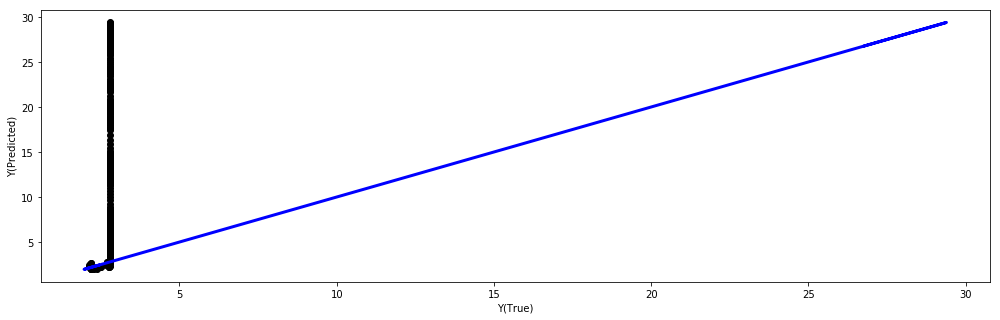

In [38]:
rf = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=100)
rf.fit(x_norm_train, y_norm_train)
y_pred = rf.predict(x_norm_valid)

print('Feature importances:')
print(rf.feature_importances_)
calc_metrics(y_pred, y_norm_valid)

### XGBRegressor

/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:33:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Root mean squared error: 93.96
Variance score: -8643.37


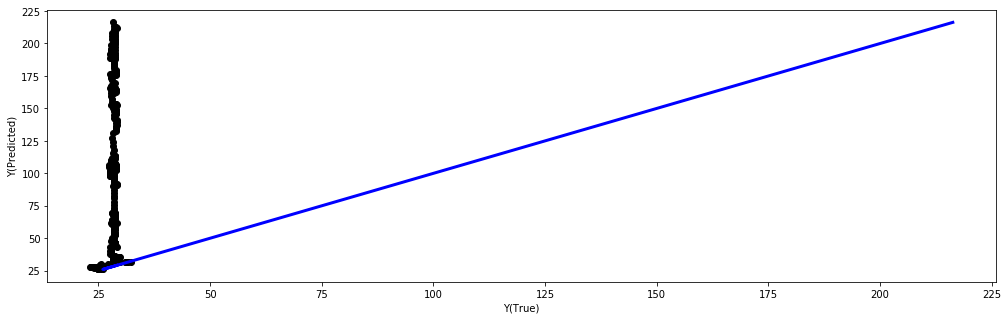

In [39]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state=42)

xgbr.fit(x_train, y_train)
y_pred = xgbr.predict(x_valid)

calc_metrics(y_pred, y_valid)

Не оптимизированная модель показала результат аналогичный модели случайного леса: в начале периода предсказания близки к фактическим значениям, затем после определенного момента предсказания очень далеки от истинных значений. Попробуем подобрать параметры max_depth и n_estimators используя grid search

In [40]:
from sklearn.model_selection import GridSearchCV

def gridsearch_cv(model, param_grid, x_train=x_train, y_train=y_train, scoring='neg_mean_squared_error'):
    grid_search = GridSearchCV(model, param_grid, cv=4, scoring=scoring)
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('\nmodel {} best {} is {}'.format(model.__class__.__name__, scoring, grid_search.best_score_))
    print('time for training is {} minutes'.format(np.round((t_end - t_start)/60)))
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    return grid_search

In [41]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
             'n_jobs':[-1],
             'random_state':[42],
             'max_depth' : [2,3,5]}
             
xgbr = xgb.XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42, reg_alpha=1.5, 
                            njobs=-1)
xgbr_res = gridsearch_cv(xgbr, param_grid)

/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:34:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:36:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:36:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:37:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

model XGBRegressor best neg_mean_squared_error is -1.6633912060502436
time for training is 4.0 minutes
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=-1, njobs=-1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=1.5, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
{'random_state': 42, 'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}


[17:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Root mean squared error: 95.03
Variance score: -19504.66


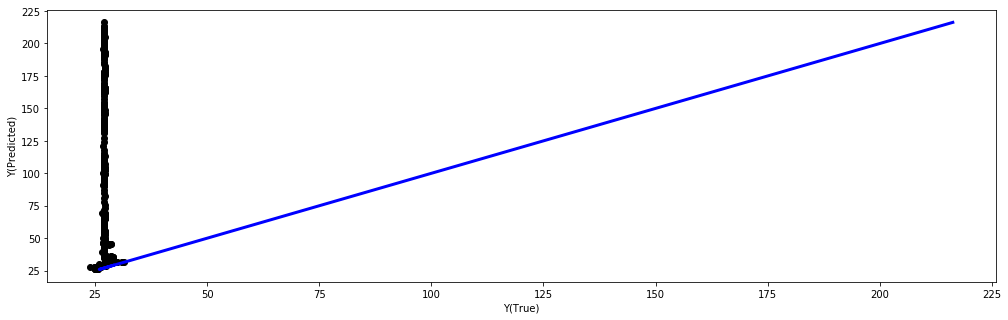

In [42]:
xgbr = xgbr_res.best_estimator_

xgbr.fit(x_train, y_train)
y_pred = xgbr.predict(x_valid)

calc_metrics(y_pred, y_valid)

Подбор параметром не улучшил качество

### Support Vector Regressor

/Users/mary/.local/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Root mean squared error: 107.31
Variance score: -912400429297366565998564600709120.00


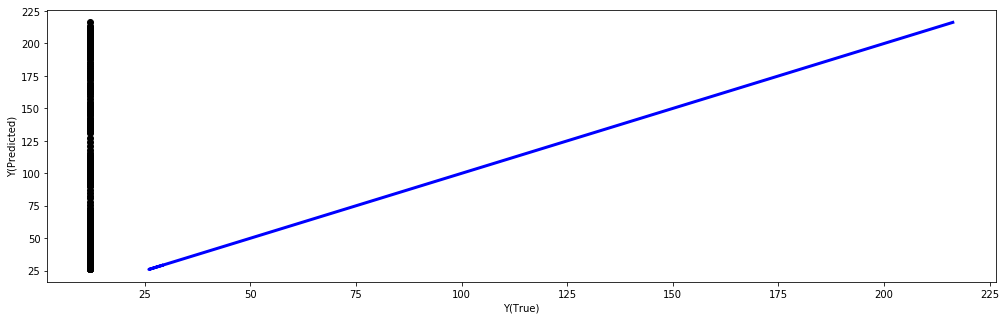

In [43]:
from sklearn.svm import SVR

svr_clf = SVR()
svr_clf.fit(x_train, y_train)
y_pred = svr_clf.predict(x_valid)

calc_metrics(y_pred, y_valid)

In [44]:
param_grid = {'gamma': ['scale'],
             'C':[0.1, 0.5, 1, 10, 100],
             'epsilon':[0.1, 1, 3, 5, 10]}
             
svr_ = SVR()
svr_res = gridsearch_cv(svr_, param_grid)


model SVR best neg_mean_squared_error is -35.503359846863084
time for training is 1.0 minutes
SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'gamma': 'scale', 'C': 0.5, 'epsilon': 5}



Root mean squared error: 106.37
Variance score: -2830.82


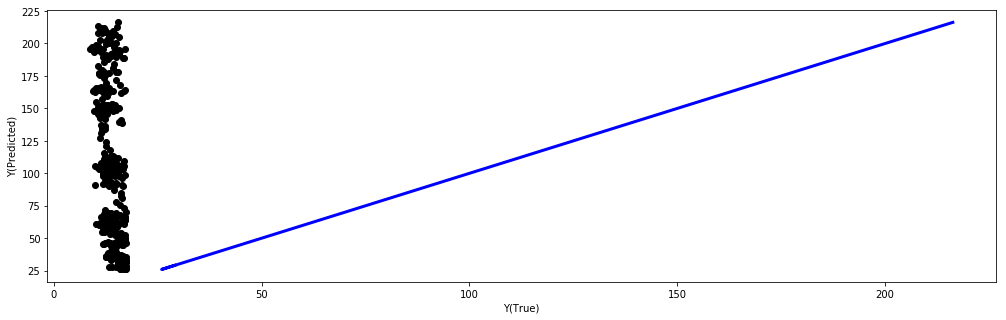

In [46]:
svr_ = svr_res.best_estimator_
svr_.fit(x_train, y_train)
y_pred = svr_.predict(x_valid)

calc_metrics(y_pred, y_valid)


Root mean squared error: 14.70
Variance score: -17521523297808732159917655679041536.00


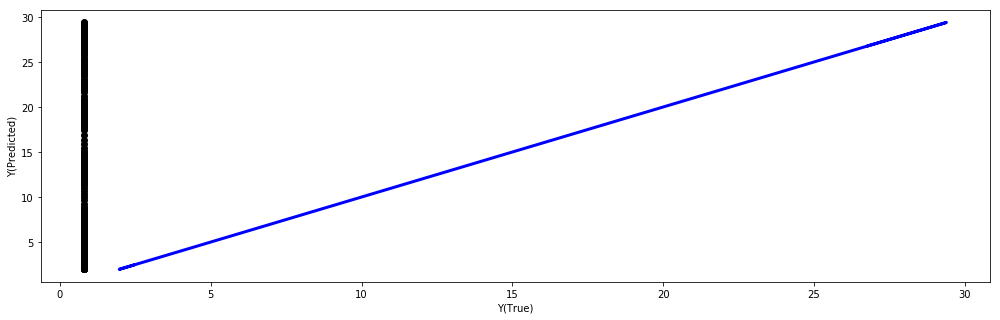

In [47]:
svr_ = svr_res.best_estimator_
svr_.fit(x_norm_train, y_norm_train)
y_pred = svr_.predict(x_norm_valid)

calc_metrics(y_pred, y_norm_valid)

SVR даже с оптимизированными параметрами отрабатывает плохо

## Шаг 6. Подведение итогов

Наилучший результат показала модель линейной регрессии. При ее применении на этапе бэктестинга на ненормализованных данных был получен положительный финансовый результат 384.95% на промежутке 2015г.-2019г. RMSE = 6.69, R^2 = 0.99. Таким образом, цель была достигнута.

Links:
* libs for live trading (from quantopian): pylivetrader and pipeline-live
* live trading https://hackernoon.com/python-library-to-run-quantopian-algorithm-in-live-5a2d6025dd45
* zipline https://quantopian.github.io/pyfolio/notebooks/zipline_algo_example/
* zipline, python for finance 
    * https://pythonprogramming.net/finance-programming-python-zipline-quantopian-intro/
    * https://pythonprogramming.net/custom-data-zipline-local-python-programming-for-finance/
* yahoo NVDA https://finance.yahoo.com/quote/NVDA/history?period1=916952400&period2=1569186000&interval=1d&filter=history&frequency=1d
* Yahoo finance for python https://pypi.org/project/yfinance/
* quantopian "Self-Serve Data", found this while searching how to download already trained model to quantopian https://www.quantopian.com/posts/upload-your-custom-datasets-and-signals-with-self-serve-data
* austrian-quant https://github.com/ademidun/austrian-quant/blob/master/quantopian/speculation_fund.py
* books:
    * The Dao of Capital: Austrian Investing in a Distorted World
    * Austrian School for Investors: Austrian Investing between Inflation and Deflation
* Quantopian tutorials: 
    * https://www.quantopian.com/tutorials/getting-started#lesson1
    * https://www.quantopian.com/tutorials
* Portfolio optimisation https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python
* Manage risk parity https://www.quantopian.com/posts/risk-parity-slash-slash-all-weather-portfolio
* Quantopian Risk Model https://www.quantopian.com/posts/new-tool-for-quants-the-quantopian-risk-model
* Libraries for backtesting http://statsmage.com/backtesting-frameworks-in-python/
* Auquan posts on medium:
    * https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05
    * https://medium.com/auquan/beginners-guide-to-quantitative-trading-ii-developing-automated-trading-systems-4c967e544f34
    * https://medium.com/auquan/developing-trading-strategies-4fc71b41d64b
    * https://medium.com/auquan/momentum-simple-trading-strategies-part-2-188cf464ffcf
    * mb main https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05
    * it's notebook https://github.com/Auquan/Tutorials/blob/master/Simple%20ML%20Strategies%20to%20generate%20Trading%20Signal.ipynb
* Scrapping financial data https://habr.com/ru/post/332700/
* Quantopian pretty full doc https://www.quantopian.com/help#api-event-properties